In [1]:
import json
import pathlib
import numpy as np
import pandas as pd
from cleanlab.outlier import OutOfDistribution   
from cleanlab.rank import find_top_issues

In [2]:
kfold = 2
loss="binary_crossentropy"
hidden_activation="relu"
output_activation="sigmoid"

PATH_EXP = pathlib.Path(f"/data/bacteria/experiments/autoencoders/6mer/02_06_2024-1/cross-validation/{loss}-{hidden_activation}-{output_activation}-{kfold}-fold/")

___
### Average distance to k NN



In [3]:
path_avg_dist_test=PATH_EXP.joinpath("data-curation/test_avg_dist.py.npy")
path_avg_dist_train=PATH_EXP.joinpath("data-curation/train_avg_dist.py.npy")

In [4]:
avg_dist_test = np.load(path_avg_dist_test)
avg_dist_train = np.load(path_avg_dist_train)


In [5]:
df_avg_dist= pd.concat([
    pd.DataFrame({"dataset":"test", "avg_dist": avg_dist_test})[:20000],
    pd.DataFrame({"dataset":"train", "avg_dist": avg_dist_train})[:20000],
])


In [ ]:
import numpy as np
p_train = np.percentile(avg_dist_train,0.99)
p_train

/home/avila/micromamba/envs/train/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


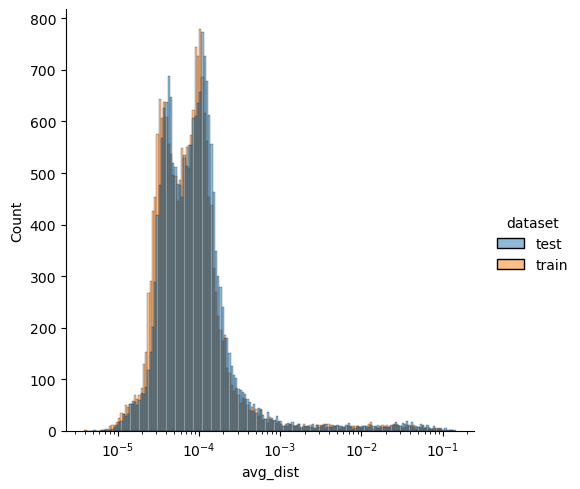

In [39]:
import seaborn as sns
import numpy as np
p = np.percentile(avg_dist_train, 99)
p

g = sns.displot(data=df_avg_dist, x="avg_dist", hue="dataset", log_scale=True)
# g.refline(x=p,y=0)

In [40]:
p

0.02123600520193577

In [30]:
p

1.2826919373765122e-05

In [20]:
len([ad for ad in avg_dist_test if ad > p])

131580

In [29]:
np.max([ad for ad in avg_dist_test if ad > p])

0.36323288

In [24]:
len([ad for ad in avg_dist_train if ad > p])

523868

In [22]:
len(avg_dist_train)

529113

## with FAISS

In [55]:
import faiss

PATH_INDEX = PATH_EXP.joinpath(f"{loss}-{hidden_activation}-{output_activation}-{kfold}-fold/faiss-embeddings/panspace.index")
index = faiss.read_index(str(PATH_INDEX))

K_NN=10

In [26]:
path_train_emb = PATH_EXP.joinpath(f"{loss}-{hidden_activation}-{output_activation}-{kfold}-fold/faiss-embeddings/embeddings.npy")
path_test_emb  = PATH_EXP.joinpath(f"{loss}-{hidden_activation}-{output_activation}-{kfold}-fold/test/embeddings.npy")

In [30]:
train_emb = np.load(path_train_emb).astype("float32")[:10000]
test_emb  = np.load(path_test_emb).astype("float32")[:1000]

In [31]:
D,I=index.search(train_emb, k=K_NN) # change to D,I

In [39]:
# compute average distance to kNN
avg_dist = D.mean(axis=1)

In [40]:
len(avg_dist)

529112

In [79]:
# find the 5th percentile of the scores (cosine similarity)
percentile = np.percentile(avg_dist, 99)
percentile

0.027642086092382695

In [80]:
len(avg_dist[avg_dist>percentile])

5292

In [56]:
D_test, I_test = index.search(test_emb, k=K_NN)

In [223]:
avg_dist_test = D_test.mean(axis=1)
len(avg_dist_test)

132279

In [83]:
len(avg_dist_test[avg_dist_test>percentile])

1500

In [88]:
avg_dist_test[avg_dist_test>percentile] 

array([0.09007378, 0.06042988, 0.03201375, ..., 0.03912099, 0.07109853,
       0.03274702], dtype=float32)

In [86]:
DD = I_test
II = D_test

In [167]:
# order in which test were embedding
path_train = PATH_EXP.parent.joinpath(f"cross-validation/train_{kfold}-fold.txt")
path_test = PATH_EXP.parent.joinpath(f"cross-validation/test_{kfold}-fold.txt")
# avg_dist_test

In [184]:
import pandas as pd
df_test = pd.read_csv(path_test, sep="\t", header=None,)
df_test.columns = ["path","label"]
df_test["avg_dist"] = avg_dist_test
df_test

,path,label,avg_dist
0,/data/bacteria/experiments/autoencoders/6mer/f...,neisseria_gonorrhoeae,0.000093
1,/data/bacteria/experiments/autoencoders/6mer/f...,escherichia_coli,0.000099
2,/data/bacteria/experiments/autoencoders/6mer/f...,salmonella_enterica,0.000048
3,/data/bacteria/experiments/autoencoders/6mer/f...,salmonella_enterica,0.000107
4,/data/bacteria/experiments/autoencoders/6mer/f...,salmonella_enterica,0.000043
...,...,...,...
132274,/data/bacteria/experiments/autoencoders/6mer/f...,salmonella_enterica,0.000037
132275,/data/bacteria/experiments/autoencoders/6mer/f...,neisseria_meningitidis,0.000134
132276,/data/bacteria/experiments/autoencoders/6mer/f...,salmonella_enterica,0.000049
132277,/data/bacteria/experiments/autoencoders/6mer/f...,mycobacterium_tuberculosis,0.000040


In [199]:
from collections import defaultdict
worst_classified=df_test.sort_values(by="avg_dist", ascending=False).query("avg_dist>0.1")

worst_classified_by_sp=defaultdict(list)
for sp, path in zip(worst_classified.label, worst_classified.path):
    worst_classified_by_sp[sp].append(path)

worst_classified_by_sp

defaultdict(list,
            {'shewanella_baltica': ['/data/bacteria/experiments/autoencoders/6mer/fcgr/dustbin__20/SAMN05720269.npy'],
             'escherichia_coli': ['/data/bacteria/experiments/autoencoders/6mer/fcgr/escherichia_coli__02/SAMEA104455087.npy',
              '/data/bacteria/experiments/autoencoders/6mer/fcgr/escherichia_coli__20/SAMN09475312.npy',
              '/data/bacteria/experiments/autoencoders/6mer/fcgr/escherichia_coli__03/SAMEA2172060.npy',
              '/data/bacteria/experiments/autoencoders/6mer/fcgr/escherichia_coli__21/SAMN09666209.npy',
              '/data/bacteria/experiments/autoencoders/6mer/fcgr/escherichia_coli__02/SAMEA104168253.npy',
              '/data/bacteria/experiments/autoencoders/6mer/fcgr/escherichia_coli__03/SAMEA1973708.npy',
              '/data/bacteria/experiments/autoencoders/6mer/fcgr/escherichia_coli__14/SAMN06266883.npy'],
             'roseburia_hominis': ['/data/bacteria/experiments/autoencoders/6mer/fcgr/roseburia_hominis

In [200]:
best_classified=df_test.sort_values(by="avg_dist", ascending=True).query("avg_dist<0.00005")
best_classified

best_classified_by_sp=defaultdict(list)
for sp, path in zip(best_classified.label, best_classified.path):
    best_classified_by_sp[sp].append(path)

best_classified_by_sp

defaultdict(list,
            {'escherichia_coli': ['/data/bacteria/experiments/autoencoders/6mer/fcgr/escherichia_coli__18/SAMN08638735.npy',
              '/data/bacteria/experiments/autoencoders/6mer/fcgr/escherichia_coli__21/SAMN09982180.npy',
              '/data/bacteria/experiments/autoencoders/6mer/fcgr/escherichia_coli__10/SAMN04262833.npy',
              '/data/bacteria/experiments/autoencoders/6mer/fcgr/escherichia_coli__10/SAMN04262952.npy',
              '/data/bacteria/experiments/autoencoders/6mer/fcgr/escherichia_coli__05/SAMEA3607423.npy',
              '/data/bacteria/experiments/autoencoders/6mer/fcgr/escherichia_coli__05/SAMEA3635251.npy',
              '/data/bacteria/experiments/autoencoders/6mer/fcgr/escherichia_coli__14/SAMN06434695.npy',
              '/data/bacteria/experiments/autoencoders/6mer/fcgr/escherichia_coli__10/SAMN04262997.npy',
              '/data/bacteria/experiments/autoencoders/6mer/fcgr/escherichia_coli__21/SAMN09982147.npy',
              '/d

In [201]:
l_sp = list(set(best_classified.label).intersection(worst_classified.label))
l_sp

['mycobacterium_tuberculosis',
 'streptococcus_pyogenes',
 'pseudomonas_aeruginosa',
 'salmonella_enterica',
 'staphylococcus_aureus',
 'clostridioides_difficile',
 'campylobacter_jejuni',
 'escherichia_coli',
 'burkholderia_pseudomallei',
 'listeria_monocytogenes']

In [202]:
worst_classified_by_sp

defaultdict(list,
            {'shewanella_baltica': ['/data/bacteria/experiments/autoencoders/6mer/fcgr/dustbin__20/SAMN05720269.npy'],
             'escherichia_coli': ['/data/bacteria/experiments/autoencoders/6mer/fcgr/escherichia_coli__02/SAMEA104455087.npy',
              '/data/bacteria/experiments/autoencoders/6mer/fcgr/escherichia_coli__20/SAMN09475312.npy',
              '/data/bacteria/experiments/autoencoders/6mer/fcgr/escherichia_coli__03/SAMEA2172060.npy',
              '/data/bacteria/experiments/autoencoders/6mer/fcgr/escherichia_coli__21/SAMN09666209.npy',
              '/data/bacteria/experiments/autoencoders/6mer/fcgr/escherichia_coli__02/SAMEA104168253.npy',
              '/data/bacteria/experiments/autoencoders/6mer/fcgr/escherichia_coli__03/SAMEA1973708.npy',
              '/data/bacteria/experiments/autoencoders/6mer/fcgr/escherichia_coli__14/SAMN06266883.npy'],
             'roseburia_hominis': ['/data/bacteria/experiments/autoencoders/6mer/fcgr/roseburia_hominis

In [219]:
all_inputs = []
all_outputs = []

paths_goods = []
paths_outliers = []

add_outliers = ["escherichia_coli", "burkholderia_pseudomallei"]

sp_outliers = add_outliers + l_sp
for sp in sp_outliers[:5]:
    print(sp)
    good = best_classified_by_sp[sp][0]
    outlier = worst_classified_by_sp[sp][0]

    paths_goods.append(good)
    paths_outliers.append(outlier)

    all_inputs.append(np.load(good))
    all_outputs.append(np.load(outlier))

escherichia_coli
burkholderia_pseudomallei
mycobacterium_tuberculosis
streptococcus_pyogenes
pseudomonas_aeruginosa


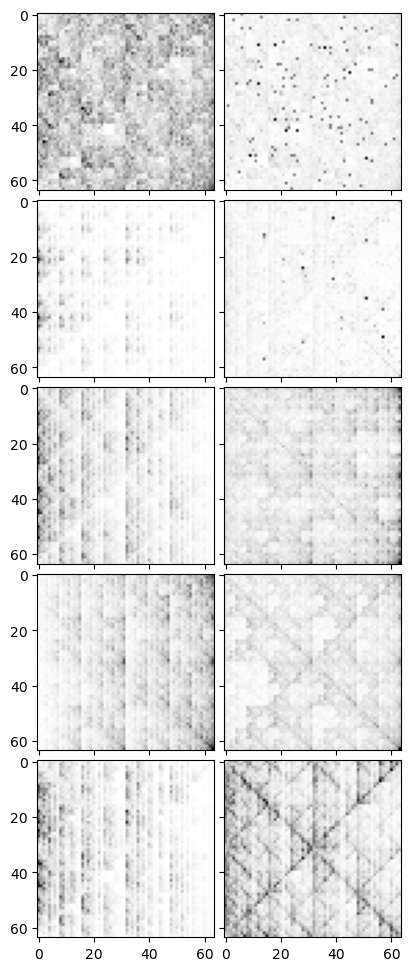

In [220]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from complexcgr import FCGR

fig = plt.figure(1,(6,12))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5,2),
                 axes_pad=0.1,
                 )
i=0
for inp, out in zip(all_inputs, all_outputs):
    grid[i].imshow(FCGR(6).plot(inp),'gray',)
    grid[i+1].imshow(FCGR(6).plot(out),'gray',)
    i+=2


In [221]:
import matplotlib.pyplot as plt
from PIL.Image import Image as PilImage
from pathlib import Path
import textwrap, os

def display_images(
    images, k, 
    columns=5, width=25, height=8, max_images=30, 
    label_wrap_length=50, label_font_size=15,
    path_save=None):

    if not images:
        print("No images to display.")
        return 

    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]

    # height = max(height, int(len(images)/columns) * height)
    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(hspace=.3)

    for i, image in enumerate(images):

        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        m=np.load(image)
        plt.imshow(FCGR(k).array2img(m),"gray")

        # if hasattr(image, 'filename'):
        title=Path(image).parent.stem.split("__")[0] + "|" + Path(image).stem 
        if title.endswith("/"): title = title[0:-1]
        title=os.path.basename(title)
        title=textwrap.wrap(title, label_wrap_length)
        title="\n".join(title)
        plt.title(title, fontsize=label_font_size)
    
    plt.tight_layout()
    
    if path_save:
        Path(path_save).parent.mkdir(exist_ok=True, parents=True)
        fig.savefig(path_save, dpi=300)
    # plt.close(fig)    

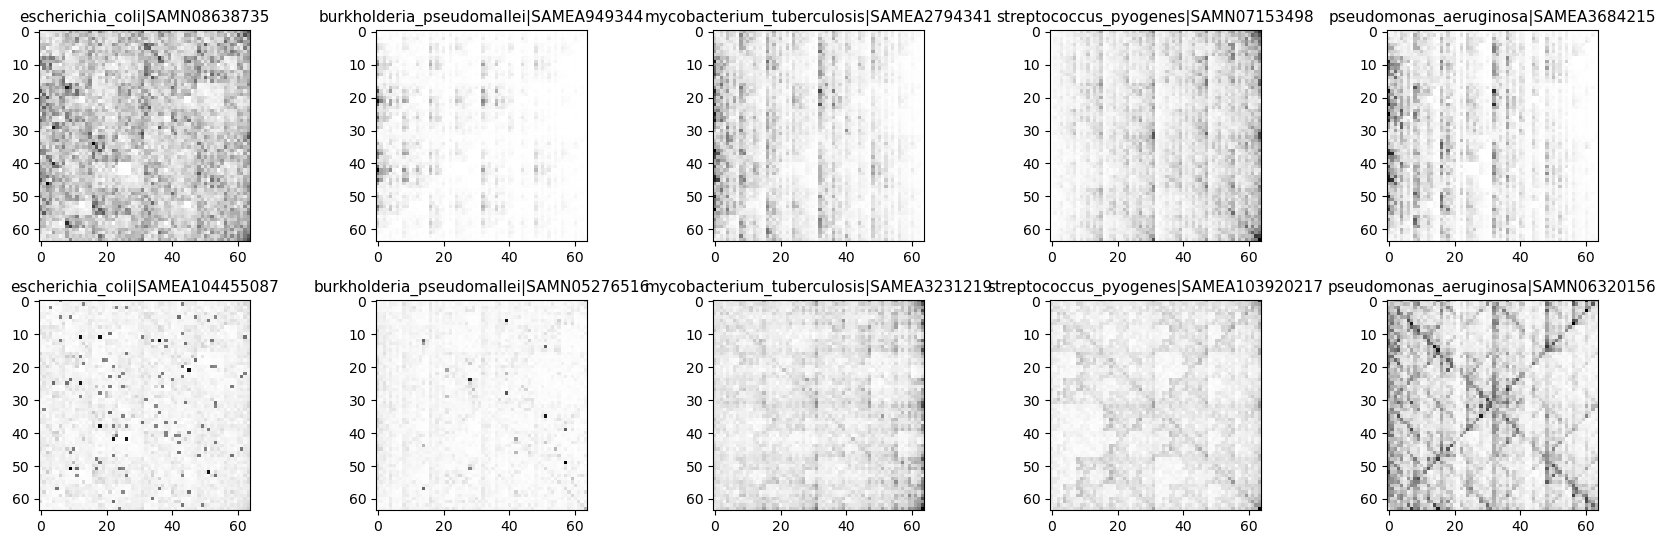

In [222]:
paths_imgs = paths_goods + paths_outliers
display_images(paths_imgs, k=6, 
            columns=5, width=17, height=8, max_images=10, 
            label_wrap_length=50, label_font_size=11,
            path_save=f"../plots/paper/complexcgr.png")

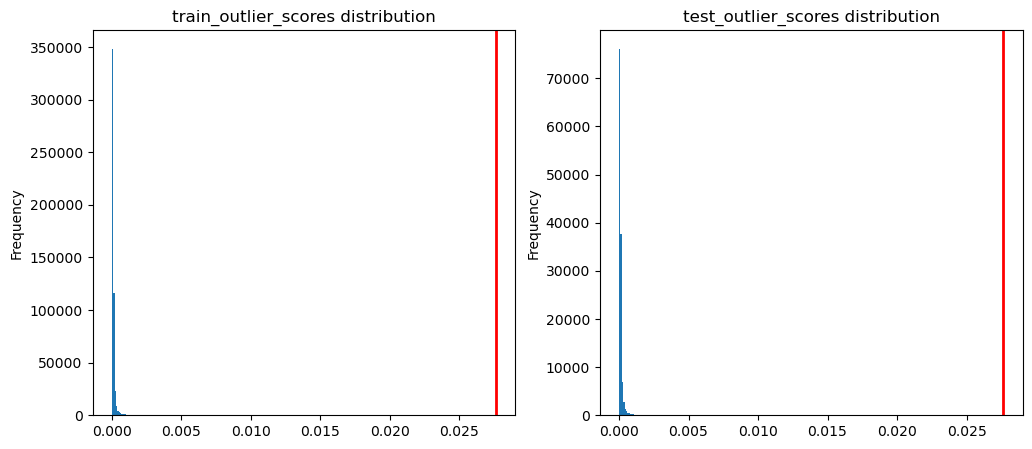

In [81]:
import matplotlib.pyplot as plt 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
plt_range = [min(avg_dist.min(),avg_dist_test.min()), \
             max(0.005,0.005)]
            #  max(avg_dist.max(),avg_dist_test.max())]
axes[0].hist(avg_dist, range=plt_range, bins=50)
axes[0].set(title='train_outlier_scores distribution', ylabel='Frequency')
axes[0].axvline(x=percentile, color='red', linewidth=2)
axes[1].hist(avg_dist_test, range=plt_range, bins=50)
axes[1].set(title='test_outlier_scores distribution', ylabel='Frequency')
axes[1].axvline(x=percentile, color='red', linewidth=2)

__

### Clean lab

In [11]:
ood = OutOfDistribution()

# To get outlier scores for train_data using feature matrix train_feature_embeddings
ood_train_feature_scores = ood.fit_score(features=train_emb)

Fitting OOD estimator based on provided features ...


In [12]:
# To get outlier scores for additional test_data using feature matrix test_feature_embeddings
ood_test_feature_scores = ood.score(features=test_emb)

In [13]:
# find the 5th percentile of the scores (cosine similarity)
fifth_percentile = np.percentile(ood_test_feature_scores, 5)

In [14]:
sorted_idxs = ood_test_feature_scores.argsort()
ood_features_scores = ood_test_feature_scores[sorted_idxs]
ood_features_indices = sorted_idxs[ood_features_scores < fifth_percentile]  # FCGR in test data flagged as outliers

In [18]:
path_list_test = PATH_EXP.joinpath(f"test_{kfold}-fold.txt")
df_test = pd.read_csv(path_list_test, sep="\t", header=None)
# df_test.iloc[ood_features_indices]
df_test

,0,1
0,/data/bacteria/experiments/autoencoders/6mer/f...,neisseria_gonorrhoeae
1,/data/bacteria/experiments/autoencoders/6mer/f...,escherichia_coli
2,/data/bacteria/experiments/autoencoders/6mer/f...,salmonella_enterica
3,/data/bacteria/experiments/autoencoders/6mer/f...,salmonella_enterica
4,/data/bacteria/experiments/autoencoders/6mer/f...,salmonella_enterica
...,...,...
132274,/data/bacteria/experiments/autoencoders/6mer/f...,salmonella_enterica
132275,/data/bacteria/experiments/autoencoders/6mer/f...,neisseria_meningitidis
132276,/data/bacteria/experiments/autoencoders/6mer/f...,salmonella_enterica
132277,/data/bacteria/experiments/autoencoders/6mer/f...,mycobacterium_tuberculosis
